The goal of this analysis is to find the most popular real estate neighborhood in the New York City.

step1: read all the data

In [2]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import DistanceMetric
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import log_loss

In [ ]:
import os
import json


import pandas as pd
import numpy as np
#os.chdir("C:/Users/jiang/Documents/kaggle")
os.chdir("../data/")
import matplotlib.pyplot as plt
train_df = pd.read_json("train.json")

step2: extract the longtitude and latitude info

In [132]:
train_df['bedroom_combine'] = train_df['bedrooms']
train_df.loc[train_df.bedrooms>5,'bedroom_combine'] = 5
bedroom = train_df.groupby(['bedroom_combine','interest_level'])['interest_level'].count()
bedroom_pcts = bedroom.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

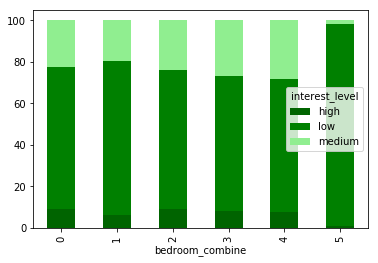

In [139]:
bedroom_pcts.unstack().plot.bar(stacked=True,color = ('Darkgreen','green','Lightgreen'))

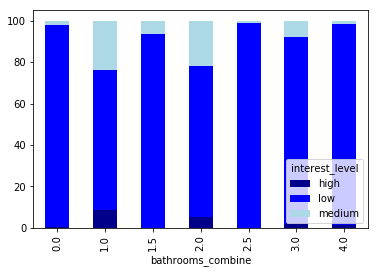

In [138]:
train_df['bathrooms_combine'] = train_df['bathrooms']
train_df.loc[train_df.bathrooms>3,'bathrooms_combine'] = 4
bathroom = train_df.groupby(['bathrooms_combine','interest_level'])['interest_level'].count()
bathroom_pcts = bathroom.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

bathroom_pcts.unstack().plot.bar(stacked=True, color = ('Darkblue','blue','Lightblue'))

In [9]:
train_coords = train_df[["listing_id", "latitude", "longitude"]]
lat= []
lon = []
listings = []

for i, j in train_coords.iterrows():
    lat.append(j["latitude"])
    lon.append(j["longitude"])
    listings.append(int(j["listing_id"]))

step3:identify the zipcode of the listing from the lon and lat

In [10]:
from uszipcode import ZipcodeSearchEngine
search = ZipcodeSearchEngine()

res = []
for i in range(len(listings)):
    try:
        res.append([listings[i],search.by_coordinate(lat[i], lon[i], radius=1, returns=1)[0]['Zipcode']])
    except:
        continue
nbd_df = pd.DataFrame(res, columns = ['listing_id','zipcode'])

step4:get the neigborhood info from the csv file

In [11]:
zip_dir="C:\Users\jiang\Documents\kaggle\zip_n.csv"
#zip_dir="../eda/zip_n.csv"
zip_n = pd.read_csv(zip_dir,header=0, names=['zipcode', 'neighborhood'])
zip_n['zipcode'] = zip_n.apply(lambda row: str(row.zipcode), axis=1)

step5:merge data together

In [12]:
train_df = train_df.merge(nbd_df, left_on='listing_id', right_on='listing_id', how='left')
train_df = train_df.merge(zip_n, left_on='zipcode', right_on='zipcode', how='left')  

In [13]:
train_df['interest'] = train_df.interest_level == 'high'
interest_high = train_df.groupby('neighborhood')['interest'].mean()
list_count = train_df.groupby('neighborhood')['neighborhood'].count()

In [14]:
print list_count[:3]
print interest_high[:3]

neighborhood
Albemarle-Kenmore Terrace    197
Arverne                        2
Astoria                      168
Name: neighborhood, dtype: int64
neighborhood
Albemarle-Kenmore Terrace    0.192893
Arverne                      0.500000
Astoria                      0.184524
Name: interest, dtype: float64


step5:print the top 5 neighborhood. There are a few neighborhood with very few listing, which may inflate the ratio of high interest listing. I am only looking at neighborhood with more than 100 listing.

In [15]:
interest_high[list_count > 100].sort_values(ascending=False).head(5)

neighborhood
Kew Gardens             0.283019
Crown Heights North     0.267241
Beverley Square West    0.192893
Flatbush                0.192893
Ditmas Park West        0.192893
Name: interest, dtype: float64

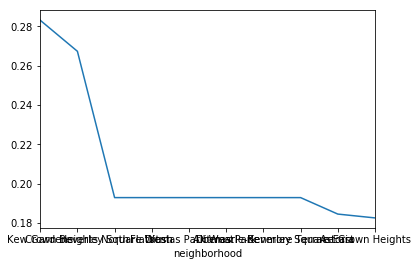

In [16]:
interest_high[list_count > 100].sort_values(ascending=False).head(10).plot()  

## Description analysis

In [17]:
train_df.description.head()

0    A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...
1    A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...
2                                                     
3    Top Top West Village location, beautiful Pre-w...
4    Building Amenities - Garage - Garden - fitness...
Name: description, dtype: object

### CounterVectorizer method

In [18]:
des = CountVectorizer()
des_matrix = des.fit_transform(train_df.description)
des_matrix.shape

(58257, 37823)

In [19]:
LR = LogisticRegression(verbose=3, solver="newton-cg", n_jobs=-1)
LR.fit(des_matrix[:40000], train_df.interest_level[:40000])

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.3s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=3, warm_start=False)

In [20]:
LR.score(des_matrix[40000:], train_df.interest_level[40000:])

0.67847948731993213

Print the most import 1 gram key words in description

In [21]:
np.argsort(LR.coef_[0])[::-1]

array([21517,  1258, 20398, ..., 18687, 17436, 22684], dtype=int64)

In [22]:
np.array(des.get_feature_names())[np.argsort(LR.coef_[0])[::-1]][:100]

array([u'julio', u'1750', u'ian', u'arturo', u'2721273', u'flawless',
       u'christie', u'yanell', u'exultant', u'bam', u'snatch', u'makr',
       u'elliot', u'kw149298', u'frame', u'floorsflex', u'premise',
       u'650350', u'loads', u'highways', u'daniel', u'easiest', u'clear',
       u'brower', u'bradhurst', u'bambi', u'factoring', u'anastasiia',
       u'capital', u'onur', u'ditmas', u'mina', u'tom', u'3668',
       u'jamesia', u'missed', u'lorenzo', u'222481', u'nassau',
       u'seperate', u'bullseye', u'canarsie', u'newby', u'9993', u'late',
       u'1bathroom', u'alex', u'brookdale', u'counts', u'1900', u'647',
       u'pine', u'standup', u'amsterdam', u'allowedparking', u'intact',
       u'personal', u'534', u'mdrn', u'morton', u'everyday', u'ashowing',
       u'afternoon', u'703', u'reputation', u'223905', u'931', u'theirs',
       u'kw150781', u'karahat', u'extras', u'kingston', u'receiving',
       u'background', u'tuesday', u'immunization', u'b35', u'abraham',
       u'

### Tfidfvectorizer analysis

In [23]:
des_idf = TfidfVectorizer(ngram_range=(1,2), stop_words = 'english')
des_matrix = des_idf.fit_transform(train_df.description)
LR_idf = LogisticRegression(verbose=3, solver="newton-cg", n_jobs=-1)
LR_idf.fit(des_matrix[:40000], train_df.interest_level[:40000])
print LR_idf.score(des_matrix[40000:], train_df.interest_level[40000:])

0.697759763378


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.1s finished


In [24]:
print np.array(des_idf.get_feature_names())[np.argsort(LR_idf.coef_[0])[::-1]][:100]

[u'rent' u'included' u'floor apartment' u'studio' u'strong' u'income'
 u'ditmas' u'ditmas park' u'utilities included' u'new' u'fee' u'flex'
 u'utilities' u'asap' u'3rd' u'personal tour' u'sunny' u'astoria'
 u'light br' u'note' u'situated' u'true' u'br open' u'value' u'renovations'
 u'includes' u'info coming' u'gut' u'new hardwood' u'set personal' u'away'
 u'credit' u'available 2016' u'queen' u'close shopping' u'best'
 u'room kitchen' u'home available' u'share' u'renovated' u'bedrooms'
 u'text' u'located heart' u'apt photos' u'clean' u'crown heights'
 u'spacious sunny' u'great price' u'jamesia' u'daniel' u'ave' u'tour today'
 u'fee unit' u'modern studio' u'actual apt' u'email' u'exclusive viewing'
 u'deal' u'viewing contact' u'perfect' u'spacious modern' u'text set'
 u'late' u'2br' u'steps' u'table' u'queen bed' u'483 6814' u'6814' u'super'
 u'excellent location' u'gut renovated' u'info' u'charming' u'crown'
 u'spacious' u'wing' u'building maintained' u'br center' u'new floors'
 u'price

In [163]:
des_matrix

<58257x313129 sparse matrix of type '<type 'numpy.float64'>'
	with 3478787 stored elements in Compressed Sparse Row format>

### SVD analysis
* shows that we only need 1 SVD?

In [25]:
des_idf = TfidfVectorizer(ngram_range=(1,2), stop_words = 'english')
des_matrix = des_idf.fit_transform(train_df.description)

for i in np.arange(10)+1:
    svd = TruncatedSVD(n_components=i)
    new_des = svd.fit_transform(des_matrix)
    LR_idf = LogisticRegression(verbose=3, solver="newton-cg", n_jobs=-1)
    LR_idf.fit(new_des[:40000], train_df.interest_level[:40000])
    print LR_idf.score(new_des[40000:], train_df.interest_level[40000:])

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


0.688174398861


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


0.687955304815


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


0.687298022676


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


0.687188475653


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


0.687626663745


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


0.688338719395


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


0.688338719395


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


0.688338719395


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


0.687298022676
0.688119625349


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


In [26]:
des_idf = TfidfVectorizer(ngram_range=(2,2), stop_words = 'english')
des_matrix = des_idf.fit_transform(train_df.description)
svd = TruncatedSVD(n_components=10)
svd.fit_transform(des_matrix)
print svd.explained_variance_ratio_

[ 0.00878815  0.01003012  0.00862346  0.00736268  0.00382872  0.00343386
  0.00270009  0.00256158  0.00239293  0.00233475]


Filter out all the digits in the description

In [27]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

In [92]:
des_idf = TfidfVectorizer(ngram_range=(2,2), stop_words = 'english', tokenizer=tokenizer.tokenize)
des_matrix = des_idf.fit_transform(train_df.description)
LR_idf = LogisticRegression()
LR_idf.fit(des_matrix[:40000], train_df.interest_level[:40000])
print LR_idf.score(des_matrix[40000:], train_df.interest_level[40000:])

0.696828613682


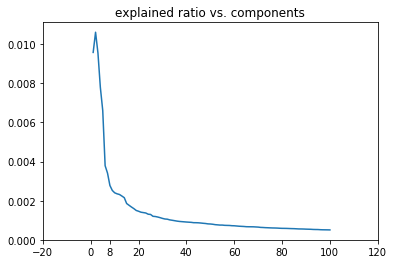

In [29]:
svd = TruncatedSVD(n_components=100)
svd.fit_transform(des_matrix)
plt.plot(np.arange(100)+1,svd.explained_variance_ratio_)
extraticks=[8]
plt.xticks(list(plt.xticks()[0]) + extraticks)
plt.title("explained ratio vs. components")
plt.show()

In [83]:
svd = TruncatedSVD(n_components=8)
description_df = pd.DataFrame(svd.fit_transform(des_matrix),columns = ['d-1','d-2','d-3','d-4','d-5','d-6','d-7','d-8'])

In [31]:
np.array(des_idf.get_feature_names())[np.argsort(LR_idf.coef_[0])[::-1]][:100]

array([u'utilities included', u'floor apartment', u'ditmas park',
       u'water included', u'gut renovated', u'exclusive viewing',
       u'personal tour', u'new hardwood', u'viewing contact',
       u'info coming', u'crown heights', u'fee unit', u'great price',
       u'home available', u'true bedroom', u'br center', u'queen bed',
       u'living room', u'set personal', u'eat kitchen', u'rent stabilized',
       u'close shopping', u'br open', u'heat hot', u'br kw',
       u'room kitchen', u'light br', u'located heart',
       u'excellent location', u'contact eli', u'spacious sunny',
       u'included rent', u'tour today', u'train station', u'good credit',
       u'free text', u'heat water', u'true br', u'just renovated',
       u'th ave', u'apt photos', u'won t', u'text set', u'br exclusive',
       u'new floors', u'kitchen bathroom', u'modern studio',
       u'amazing deal', u'hardwood floors', u'location near', u'studio br',
       u'text anytime', u'spacious modern', u'steps away'

Neighborhood factor prediction

In [32]:
train_nb = pd.get_dummies(train_df.neighborhood)

In [33]:
LR_nb = LogisticRegression()
LR_nb.fit(train_nb[:40000], train_df.interest_level[:40000])
print LR_nb.score(train_nb[40000:], train_df.interest_level[40000:])

0.68850303993


## City columns

In [34]:
city = []
for i in range(len(listings)):
    try:
        city.append([listings[i],search.by_coordinate(lat[i], lon[i], radius=1, returns=1)[0]['City']])
    except:
        continue
city_df = pd.DataFrame(city, columns = ['listing_id','city'])

In [35]:
city_dummy = pd.get_dummies(city_df)
train_df_list = pd.DataFrame(train_df['listing_id'])
train_df_list = train_df_list.merge(city_dummy, left_on='listing_id', right_on='listing_id', how='left')

In [36]:
train_df_list=train_df_list.fillna(0)

In [37]:
del train_df_list['listing_id']

## Features

In [147]:
import scipy.sparse as sp
feature_list = []
for i in train_df.features:
    feature_list.extend(i)
names = list(set(feature_list))

In [39]:
voc2id = dict(zip(names, range(len(names))))

convert features to sparse matrix

In [40]:
rows, cols, vals = [], [], []
for r, d in enumerate(train_df.features):
    for e in d:
        if voc2id.get(e) is not None:
            rows.append(r)
            cols.append(voc2id[e])
            vals.append(1)
features = sp.csr_matrix((vals, (rows, cols)))

In [41]:
LR_features = LogisticRegression()
LR_features.fit(features[:40000], train_df.interest_level[:40000])
print LR_features.score(features[40000:], train_df.interest_level[40000:])

0.689872377718


In [161]:
id2voc = {v: k for k, v in voc2id.iteritems()}
for i in np.argsort(LR_features.coef_[0])[::-1][:100]:
    print id2voc[i]
    

Actual Apt. Photos
Concierge Service
One Month Free
Sunlight
Storage
Walk-in-closet
Pets: Cats/Small Dogs
Near Transportation
Short Term Allowed
** SPACIOUS STUDIO SUPREME * AMAZING CORNER LAYOUT * TONS OF SUNLIGHT * PETS OK **
** OVERSIZED & UNDERPRICED * CLASSY CORNER STUDIO * ALL MODERN & NEW * PERFECT SUNLIGHT * PETS OK **
** OVERSIZED 3BR HOME * SPARKLING CLEAN * TONS OF NATURAL LIGHT * 2 BLKS TO THE WATERFRONT & BEDFORD L STOP **
Stunning Renovations
Hardwood
Sauna
Kitchen Pantry
Walk-In Closet
Live-in superintendent
Renovated Kitchen
Exposed Brick
Stainless Steel Kitchen
Roof
Playroom
Owner Occupied - 3 family townhouse - no realtor fees - this beautiful apt is offered below market rate
Stunning New Renovation
4th floor Walk Up
Private backyard
stainless steel
Available  05/15/16    Dishwasher
Newly renovated
Laundry In Building
Near PRATT
Near Subway
Air Conditioning
Furnished
Bike Room
True 2 Bedroom - On Lexington Ave
** OVERSIZED & UNDERPRICED! * SPRAWLING SUNFILLED STUDIO *

In [42]:
for i in np.arange(10)+1:
    svd = TruncatedSVD(n_components=i)
    new_des = svd.fit_transform(features)
    LR_idf = LogisticRegression()
    LR_idf.fit(new_des[:40000], train_df.interest_level[:40000])
    print LR_idf.score(new_des[40000:], train_df.interest_level[40000:])

0.688338719395
0.688338719395
0.688338719395
0.688010078326
0.688064851838
0.688174398861
0.688776907488
0.689324642603
0.689324642603
0.688612586953


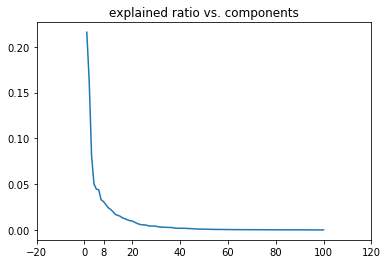

In [164]:
svd = TruncatedSVD(n_components=100)
svd.fit_transform(features)
plt.plot(np.arange(100)+1,svd.explained_variance_ratio_)
extraticks=[8]
plt.xticks(list(plt.xticks()[0]) + extraticks)
plt.title("explained ratio vs. components")
plt.show()

In [165]:
sum(svd.explained_variance_ratio_[:10])

0.71463243798957732

In [81]:
svd = TruncatedSVD(n_components=8)
features_svd = pd.DataFrame(svd.fit_transform(features),columns = ['f-1','f-2','f-3','f-4','f-5','f-6','f-7','f-8'])

Combine all columns

In [45]:
train_df.columns

Index([      u'bathrooms',        u'bedrooms',     u'building_id',
               u'created',     u'description', u'display_address',
              u'features',  u'interest_level',        u'latitude',
            u'listing_id',       u'longitude',      u'manager_id',
                u'photos',           u'price',  u'street_address',
               u'zipcode',    u'neighborhood',        u'interest'],
      dtype='object')

In [46]:
neighborhood_df = pd.get_dummies(train_df.neighborhood)

In [47]:
useful_df = train_df[['bathrooms','bedrooms','price']]
frames = [useful_df, features_svd, description_df,train_df_list,neighborhood_df]
result = pd.concat(frames, axis=1)
result = result.fillna(0)

Fitting model

In [48]:
xgb = GradientBoostingClassifier()
xgb.fit(result[:40000], train_df.interest_level[:40000])
xgb.score(result[40000:],train_df.interest_level[40000:])

0.71046721805334945

In [49]:
result.shape

(58257, 213)

## Another way of neigborhood code

I get the following neighborhood names from the Renthop nyc website. The latitude and longitude of the neighborhood is gotten with the geopy.geocodes. The correponsing neighborhood is returned by calculated the distance between the listing building and the center of the neighborhood.

I notice there are some wrong records in the records, which give me a location in Chicago or even farther. I remove all listing with distance greater than 10.

In [50]:
from geopy.geocoders import Nominatim

In [51]:
m_neighborhoods = ['Battery Park City','Bowery','Chinatown','Civic Center','East Village','Financial District',
                   'Greenwich Village','Little Italy','Lower East Side','NoHo','NoLita','SoHo','Tribeca','Two Bridges',
                   'West Village','Chelsea','Flatiron District','Garment District','Gramercy Park',"Hell's Kitchen",'Kips Bay',
                   'Koreatown','Midtown East','Murray Hill','NoMad','Stuyvesant Town - Peter Cooper Village','Theater District',
                   'Central Harlem','Central Park','East Harlem','Inwood','Upper East Side','Upper West Side',
                   'Washington Heights','West Harlem','Randalls-Wards Island','Roosevelt Island']
        
b_neighborhoods = ['Bedford-Stuyvesant','Bushwick','Greenpoint','Williamsburg','Boerum Hill','Carroll Gardens','Cobble Hill',
                   'Gowanus','Greenwood Heights','Park Slope','Prospect Park','Red Hook','Sunset Park','Windsor Terrace',
                   'Crown Heights','East Flatbush','Flatbush','Kensington','Midwood','Ocean Hill','Brooklyn Heights',
                   'Brooklyn Navy Yard','Clinton Hill','DUMBO','Downtown Brooklyn','Fort Greene','Prospect Heights',
                   'Vinegar Hill','Bath Beach','Bay Ridge','Bensonhurst','Borough Park','Dyker Heights','Mapleton',
                   'Brighton Beach','Coney Island','Gravesend','Sheepshead Bay','Brownsville','Canarsie','Cypress Hills',
                   'East New York','Bergen Beach','Flatlands','Floyd Bennett Airfield','Marine Park','Mill Basin']

q_neighborhoods = ['Astoria','Corona','East Elmhurst','Elmhurst','Forest Hills','Glendale','Jackson Heights','Long Island City',
                   'Maspeth','Middle Village','Rego Park','Ridgewood','Sunnyside','Woodside','Auburndale','Bayside',
                   'College Point','Flushing','Flushing Meadows-Corona Park','Fresh Meadows','Glen Oaks','Kew Gardens',
                   'Kew Gardens Hills','Whitestone','Briarwood','Hollis','Holliswood','Jamaica','Jamaica Estates',
                   'Jamaica Hills','South Jamaica','St. Albans','Forest Park','Howard Beach','Ozone Park','Richmond Hill',
                   'South Ozone Park','Woodhaven','Far Rockaway','Rockaway Beach']

s_neighborhoods =  ['East Shore','Mid-Island','North Shore','South Shore']

bx_neighborhoods = ['Bedford Park','Belmont','Bronx Park','Concourse','Concourse Village','East Tremont','Fordham Heights',
                    'Fordham Manor','Highbridge','Hunts Point','Kingsbridge','Longwood','Marble Hill','Morris Heights',
                    'Morrisania','Mott Haven','Mount Eden','Mount Hope','Norwood','Riverdale','University Heights',
                    'Van Cortlandt Park','West Farms','Allerton','Clason Point','Morris Park','Parkchester','Pelham Bay',
                    'Pelham Parkway','Throgs Neck','Unionport','Van Nest','Wakefield','Westchester Village','Williamsbridge',
                    'Woodlawn Heights']

nj_neighborhoods = ['Bergen - Lafayette',
                    'Greenville','Historic Downtown','McGinley Square','The Heights','The Waterfront','West Side']

In [52]:
neighborhood_list = ['m_neighborhoods','b_neighborhoods','q_neighborhoods','s_neighborhoods','bx_neighborhoods','nj_neighborhoods']
n_dict = {'m_neighborhoods':'manhattan','b_neighborhoods':'brooklyn','q_neighborhoods':'queens',
          's_neighborhoods':'staten island','bx_neighborhoods':'bronx','nj_neighborhoods':'new jersey'}

Some neighborhoods cannot be automatically located through geopy. I searched it out in Google and fill it out mannualy.

In [54]:
neighborhood_dict= {}
for n_list in neighborhood_list:
    for n in eval(n_list):
        geolocator = Nominatim()
        location = geolocator.geocode(n+" "+n_dict[n_list])
        try:
            neighborhood_dict[n]=(location.latitude, location.longitude)
        except:
            print n_list +":"+ n
            continue

m_neighborhoods:NoLita
m_neighborhoods:Two Bridges
m_neighborhoods:Flatiron District
m_neighborhoods:Garment District
m_neighborhoods:Stuyvesant Town - Peter Cooper Village
m_neighborhoods:Randalls-Wards Island
b_neighborhoods:Floyd Bennett Airfield
q_neighborhoods:Jamaica Hills
s_neighborhoods:East Shore
s_neighborhoods:Mid-Island
s_neighborhoods:North Shore
s_neighborhoods:South Shore
bx_neighborhoods:Westchester Village
nj_neighborhoods:Bergen - Lafayette
nj_neighborhoods:Historic Downtown
nj_neighborhoods:McGinley Square
nj_neighborhoods:West Side


In [55]:
neighborhood_dict['Nolita'] = (40.7230413,-73.9948607)
neighborhood_dict['Two Bridges'] = (40.71074689999999,-73.99696)
neighborhood_dict['Flatiron District'] = (40.74008300000001,-73.99034890000001)
neighborhood_dict['Garment District'] = (40.7547072,-73.99163420000002)
neighborhood_dict['Stuyvesant Town - Peter Cooper Village'] = (40.7316903,-73.97784939999997)
neighborhood_dict['Randalls-Wards Island'] = (40.7932271,-73.92128579999996)
neighborhood_dict['Floyd Bennett Airfield'] = (40.5910174,-73.8906091)
neighborhood_dict['Jamaica Hills'] = (40.71280290000001,-73.79926339999997)
neighborhood_dict['East Shore'] = (40.606221,-74.06419489999996)
neighborhood_dict['Mid-Island'] = (40.5993847,-74.17931770000001)
neighborhood_dict['North Shore'] =(40.62604414772478,-74.12667847936973)
neighborhood_dict['South Shore'] = (40.531910867376595,-74.21559907263145)
neighborhood_dict['Westchester Village'] = (40.8407103,-73.8473591)
neighborhood_dict['Bergen - Lafayette'] =(40.71114639999999,-74.07407289999998)
neighborhood_dict['Historic Downtown'] =(40.71114639999999,-74.07407289999998)
neighborhood_dict['McGinley Square'] = (40.7241223,-74.06966729999999)
neighborhood_dict['West Side'] =(40.7247507,-74.08288390000001)

In [56]:
neighborhood_df = pd.Series(neighborhood_dict)

Calculate the distance betweent the building and the center of the neighborhood

In [57]:
dist = DistanceMetric.get_metric('euclidean')
X = list(neighborhood_df)

min_distance = np.zeros(train_df.shape[0])
min_index = []
count = 0
for listing in np.array(train_df[['latitude','longitude']]) :   
    min_distance[count] = np.min(dist.pairwise(X,[listing]), axis = 0)
    if np.min(dist.pairwise(X,[listing]), axis = 0) < 10:
        min_index.append(neighborhood_df.index[np.argmin(dist.pairwise(X,[listing]))])
    else:
        min_index.append(np.nan)
    count += 1
min_index = np.array(min_index)

In [58]:
n_df = pd.get_dummies(min_index)
n_df = n_df.fillna(0)

In [166]:
n_df.shape

(58257, 158)

A brief plot of the distance (only show 16 listing with maxium distance)

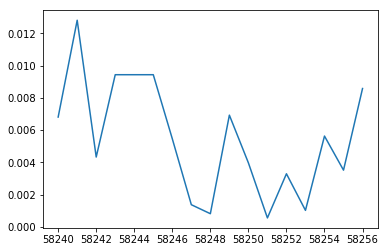

In [59]:
plt.plot(range(train_df.shape[0])[58240:],min_distance[58240:])
plt.show()

## Trying differnt kinds of input and see the accuaracy
I try to use gridsearch for xgb. However, it is extremely slow , so I just try different combinations of the parameters

In [278]:
frames = [useful_df, features_svd, description_df]
result = pd.concat(frames, axis=1)
result = result.fillna(0)
xgb = GradientBoostingClassifier()
xgb.fit(result[:40000], train_df.interest_level[:40000])
xgb.score(result[40000:],train_df.interest_level[40000:])

0.7120556498877143

In [279]:
frames = [useful_df, features_svd,n_df]
result = pd.concat(frames, axis=1)
result = result.fillna(0)
xgb = GradientBoostingClassifier()
xgb.fit(result[:40000], train_df.interest_level[:40000])
xgb.score(result[40000:],train_df.interest_level[40000:])

0.71030289751875997

In [277]:
frames = [useful_df, features_svd, n_df,description_df]
result = pd.concat(frames, axis=1)
result = result.fillna(0)
xgb = GradientBoostingClassifier()
xgb.fit(result[:40000], train_df.interest_level[:40000])
xgb.score(result[40000:],train_df.interest_level[40000:])

0.71232951744536344

In [283]:
frames = [useful_df, features_svd, n_df,description_df]
result = pd.concat(frames, axis=1)
result = result.fillna(0)
xgb = GradientBoostingClassifier(max_depth = 10)
xgb.fit(result[:40000], train_df.interest_level[:40000])
xgb.score(result[40000:],train_df.interest_level[40000:])

0.72103850577860551

In [284]:
frames = [useful_df, features_svd, n_df,description_df]
result = pd.concat(frames, axis=1)
result = result.fillna(0)
xgb = GradientBoostingClassifier(n_estimators = 300)
xgb.fit(result[:40000], train_df.interest_level[:40000])
xgb.score(result[40000:],train_df.interest_level[40000:])

0.7166566248562195

In [84]:
frames = [useful_df, features_svd, n_df,description_df]
result = pd.concat(frames, axis=1)
result = result.fillna(0)
X_train, X_val, y_train, y_val = train_test_split(result, train_df.interest_level, test_size=0.33)

In [85]:
names = ["kNN", "LR", "Random Forest", "AdaBoost", "NB","XGB"]
classifiers = [
    KNeighborsClassifier(5),
    LogisticRegression(solver="newton-cg"),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB(),
    GradientBoostingClassifier()
]
clf_dict = dict(zip(names, classifiers))
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print name, log_loss(y_val, clf.predict_proba(X_val))

kNN 3.06167773884


C:\Users\jiang\Anaconda2\lib\site-packages\scipy\optimize\linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\jiang\Anaconda2\lib\site-packages\scipy\optimize\linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


LR 0.674051436508


C:\Users\jiang\Anaconda2\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Random Forest 0.632866539293
AdaBoost 1.08454238181
NB 1.56153794076
XGB 0.633757186958


In [86]:
num_feats = list(result.columns)

In [87]:
import operator

In [88]:
sorted(zip(num_feats, clf_dict["Random Forest"].feature_importances_), key=operator.itemgetter(1),reverse = True)

[(u'price', 0.11024028364433074),
 ('d-3', 0.05469043285033319),
 ('d-5', 0.053786752601097228),
 ('d-2', 0.053491859977385647),
 ('d-1', 0.052124121617321634),
 ('d-4', 0.050368219897281373),
 ('d-6', 0.050283820639614875),
 ('d-7', 0.050085405931078866),
 ('d-8', 0.04932346336824487),
 ('f-5', 0.042359564102736107),
 ('f-2', 0.041088598469610736),
 ('f-7', 0.039477563720485748),
 ('f-4', 0.039322800925987965),
 ('f-3', 0.038941448160511767),
 ('f-8', 0.03771690363294742),
 ('f-1', 0.037299438037555477),
 ('f-6', 0.036680567177647894),
 (u'bedrooms', 0.028706854851100548),
 (u'bathrooms', 0.010604507069238657),
 ('Upper East Side', 0.0061395502406760873),
 ('East Village', 0.0042685270862557389),
 ('Upper West Side', 0.0037039137269311217),
 ('Greenwich Village', 0.0035417276532250059),
 ('Murray Hill', 0.0035006432227910333),
 ('Civic Center', 0.0035003053054920214),
 ('Flatbush', 0.0033655339314209065),
 ('Chelsea', 0.0031582125290455765),
 ('Midtown East', 0.0029557623519429559),
 